### Copyright(c) [2024] [Xuan Huyen Nguyen]

This project is part of the CSIT946 subject at UoW, where the work involves processing different types of numeric and text data to classify Twitter accounts. The code is provided for educational purposes and demonstration use only. 

DISCLAIMER: It comes with no guarantees or warranties, and I, as the author, am not liable for any issues that arise from its use. While you're welcome to learn from it, please do not copy or distribute it for your own coursework or assignments without permission.


## IMPORT LIBRARIES

In [76]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import words
nltk.download('words')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.simplefilter("ignore") # Ignore all warnings
from sklearn.metrics import confusion_matrix
import string
import re
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package words to
[nltk_data]     /Users/huyennguyen_goodnotes/nltk_data...
[nltk_data]   Package words is already up-to-date!


## PROCEED THE TRAIN SET 

In [42]:
# now going back to the non-golden data (only 20k row), 
user_df = pd.read_csv('train_data.csv', encoding='latin-1')
user_df.describe()

,_unit_id,_trusted_judgments,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,tweet_id,is_non-human
count,1.635900e+04,16359.0,16359.000000,16359.000000,16359.000000,16359.000000,1.635900e+04,1.635900e+04,16359.000000
mean,8.157294e+08,3.0,0.919633,0.996030,4344.938199,0.087475,3.864531e+04,6.587350e+17,0.314628
std,5.875489e+03,0.0,0.142403,0.036272,12333.804881,2.926451,1.188100e+05,5.000148e+12,0.464382
min,8.157192e+08,3.0,0.621200,0.631000,0.000000,0.000000,1.000000e+00,6.587300e+17,0.000000
25%,8.157243e+08,3.0,1.000000,1.000000,13.000000,0.000000,2.429500e+03,6.587300e+17,0.000000
50%,8.157294e+08,3.0,1.000000,1.000000,471.000000,0.000000,1.124100e+04,6.587400e+17,0.000000
75%,8.157344e+08,3.0,1.000000,1.000000,3304.500000,0.000000,3.970000e+04,6.587400e+17,1.000000
max,8.157396e+08,3.0,1.000000,1.000000,341621.000000,330.000000,2.680199e+06,6.587400e+17,1.000000


In [43]:
print(user_df.columns)

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'link_color', 'name', 'profileimage', 'retweet_count', 'sidebar_color',
       'text', 'tweet_coord', 'tweet_count', 'tweet_created', 'tweet_id',
       'tweet_location', 'user_timezone', 'is_non-human'],
      dtype='object')


In [44]:
# Get the unique values in the 'is_non-human' column
unique_label = user_df['is_non-human'].unique()

# Print the unique values
print(unique_label)


[0. 1.]


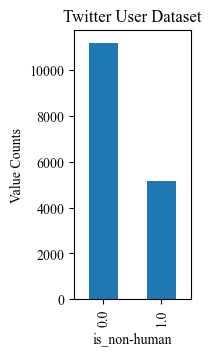

In [45]:
# plot the human and non-human counts
ax = user_df['is_non-human'].value_counts().plot(kind='bar', figsize=(1.5,3.5))
fig = ax.get_figure()
ax.set_title("Twitter User Dataset")
ax.set_xlabel('is_non-human')
ax.set_ylabel('Value Counts');

### Remove columns

In [46]:
user_df["is_non-human"].value_counts()

is_non-human
0.0    11212
1.0     5147
Name: count, dtype: int64

In [47]:
column_names = list(user_df.columns)

# Print the list of column names
print(column_names)


['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn', 'profile_yn:confidence', 'created', 'description', 'fav_number', 'link_color', 'name', 'profileimage', 'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone', 'is_non-human']


### Drop the unnecessary columns as we only need text column

In [48]:
# now drop the unneccesary columns
drop_columns = ['_unit_id', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'gender', 
                   'gender:confidence', 'profile_yn', 'profile_yn:confidence', 'created', 'fav_number', 
                   'link_color', 'name', 'profileimage', 'retweet_count', 'sidebar_color', 
                   'tweet_coord', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 
                   'user_timezone']


# drop others columns as we only do text analysis
proceed_user_df = user_df.drop(columns=drop_columns)

In [49]:
# Reset the index and add it as a column
proceed_user_df.reset_index(inplace=True)

In [50]:
column= list(proceed_user_df.columns)

# Print the list of column names
print(column)

['index', '_golden', 'description', 'text', 'is_non-human']


In [51]:
proceed_user_df.head()

,index,_golden,description,text,is_non-human
0,0,False,I love one direction!!!!,I Just d for @onedirection for #ArtistOfTheYea...,0.0
1,1,False,ÂÂ£ÃApple geekÂÂ£Ã\nÂ_Ã https://t.co/mHj...,Photo by @kikeo: A great white #shark smiles f...,0.0
2,2,False,University Innovation Fellows are student chan...,150 new #uifellows from 52 U.S. institutions h...,1.0
3,3,False,rather be dead than red,@CriminalCosta @Yedlinho and that hahaha,0.0
4,4,False,#social media #bigdata #marketing #seo\nPlease...,Running together for customer engagement: Appl...,0.0


# APPROACH & METHOD: 
- BAG OF WORDS and LOGISTIC REGRESSION

## Preprocess before applying bag of words
- The text and description columns have been merged into a single column called combined_text for the purpose of text analysis. This merging takes place after applying a function called cleanTweet to process the tweet within those two columns, with some of the techniques mentioned by Wahome (2018).
- The details of the operations used to clean the tweets are described as below. After applying the series of cleaning operations to the tweet, if any tweet becomes empty as a result of this process, it is filtered out and removed from the dataset. This ensures that only tweets with meaningful content are retained for further analysis.

In [52]:
# Preprocess the tweet data 
punctuation = string.punctuation

# a function to clean tweets
def cleanTweet(tweet):
    # Eliminate HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    # Change @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Handle tickers by removing the $
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase by converting the tweets to lowercase
    tweet = tweet.lower()
    # Handle hyperlinks by removing the link entirely
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Deal with hashtags by removing '#' sign and the word following it
    tweet = re.sub(r'#\w*', '', tweet)
    # Eliminate Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Eliminate numbers
    tweet = re.sub(r'\d', '', tweet)
    # Eliminate words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Eliminate whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Eliminate characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    # Remove non english character
    tweet = re.sub('[^\x00-\x7F]', '',tweet)
    # Remove repeated space
    tweet = re.sub(r'\s+', ' ', tweet)
    # Remove repeated characters
    tweet = re.sub(r'(.)\1+', r'\1\1',tweet)
    # Trim space at the beginning and end of tweet
    tweet = tweet.strip()
    # Remove stopwords
    tweet = ' '.join(word for word in tweet.split() if word not in stopwords.words('english'))
    

    return tweet
# ______________________________________________________________
# clean dataframe's tweet column
proceed_user_df['text'] = proceed_user_df['text'].apply(cleanTweet)

# Replace null values in "description" column with empty strings
proceed_user_df['description'].fillna('', inplace=True)

# clean dataframe's tweet column
proceed_user_df['description'] = proceed_user_df['description'].apply(cleanTweet)

### Combine text and description column

In [53]:
# Combine "text" and "description" columns
proceed_user_df['combined_text'] = proceed_user_df['description'] + ' ' + proceed_user_df['text']

In [54]:
# changing df to list of string preparing for the corpus
corpus = proceed_user_df['combined_text'].to_list()
label = proceed_user_df['is_non-human'].to_list()

### Remove  records in the corpus with empty words, making into new corpus and new label


In [55]:
#remove records in the corpus with empty words
def contains_word(s):
    return any(i.isalpha() for i in s.split())

# Make a new corpus and label
new_corpus = []
new_label = []
# remove empty record
for i, v in enumerate(corpus):
    if contains_word(v):
        new_corpus.append(v) # adding value of the corpus to the new_corpus
        new_label.append(label[i]) # adding index of the label to the new_label

In [18]:
new_corpus

[' get weather updates weather channel',
 'kid always early class make awkward small talk professor finish hour critique nothing makes sense anymore',
 'book holic anime manga fan gamer movie fanatic collector book blogger think wrong twitter account linked author checked auth website different twitter acct',
 'young woman rapid growth humble understanding fierce spirituality substantial intellect abundant creativity powerful presence hung person thought entire time never hanging',
 ' growing eyebrows longest ugliest process',
 'things gives strength glen really die walking dead done even think killing daryl def done',
 'want never herd yall ladies nigga keep tryna talk interested start telling problems',
 'praying real spread come play game came play part',
 'win race run waage months road trip',
 ' abrasive unelectable general election',
 'take bad good keep keeping divorce statistics high marriages last cuz bags say ring plug hole shit like',
 'mad magic lie fire madalyndenise tired

In [56]:
# check the length of both corpus and label
len(new_corpus), len(new_label)

(16318, 16318)

## Apply countVectorizer()
- When it comes to tweet data and text analysis, the Bag of Words (BoW) technique is commonly associated with Logistic Regression as a classification method (Adom, 2022). BoW involves converting each tweet into a feature vector composed of distinct words, which is subsequently utilized as input for a classifier (Adom, 2022). Due to their simplicity and ease of interpretation, BoW and Logistic Regression serve as a vanilla approach for text analysis, often employed as a baseline against which other methods can be compared. We will be utilizing the scikit-learn library, which includes the CountVectorizer (scikit learn, 2022) for text preprocessing and the Logistic Regression algorithm (scikit learn, 2023) for our analysis.

In [57]:
vectorizer = CountVectorizer() #ngram_range=(1, 2)
X = vectorizer.fit_transform(new_corpus)

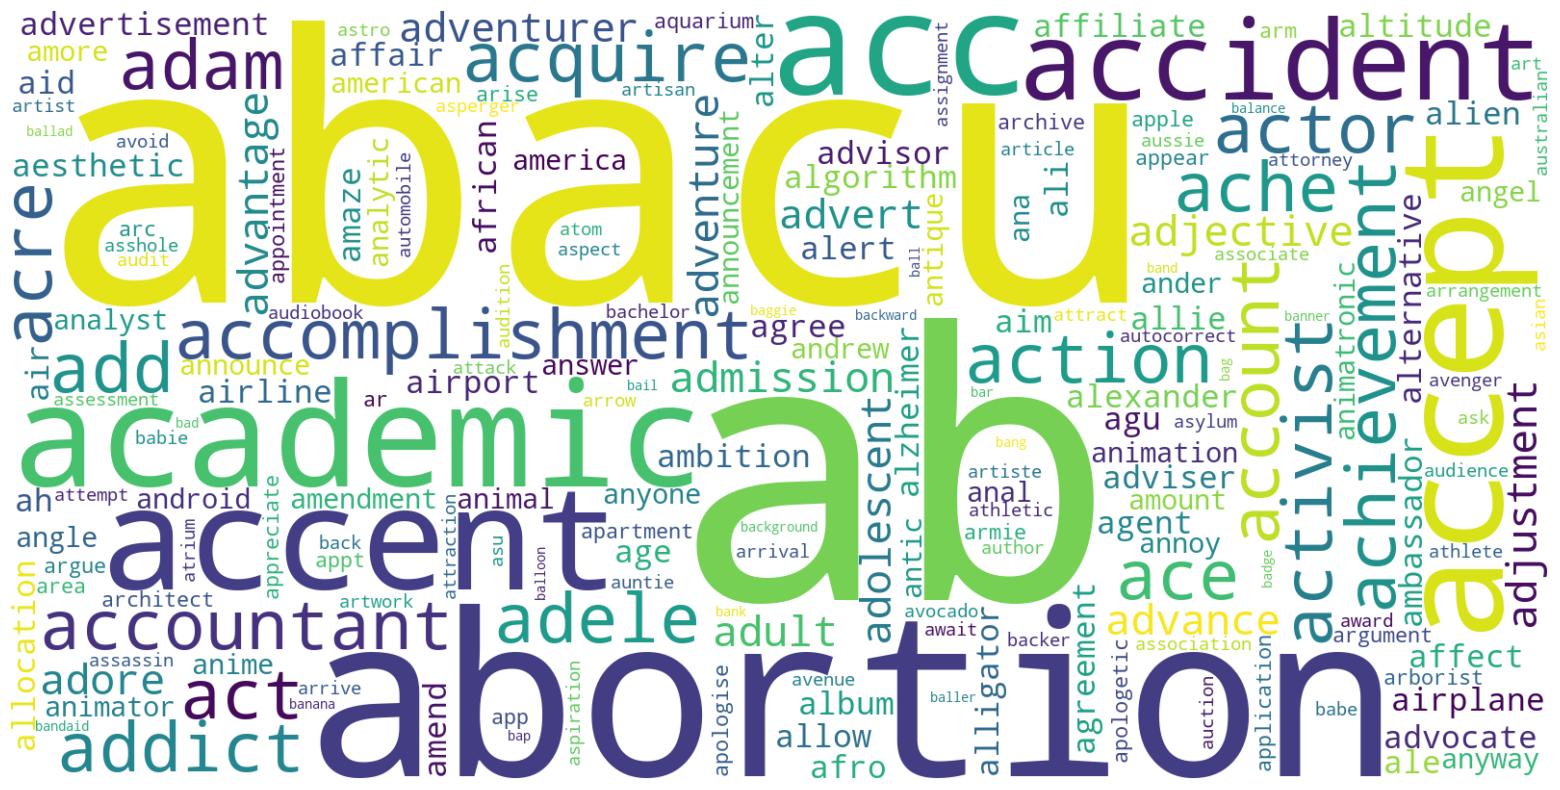

In [58]:

# wordcloud on the features names
feature_names = vectorizer.get_feature_names_out()

# Generate a word cloud image
wordcloud = WordCloud(width=1600, height=800, background_color='white',random_state=22).generate(' '.join(feature_names))

# Display the generated word cloud image
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [59]:
X.shape

(16318, 31938)

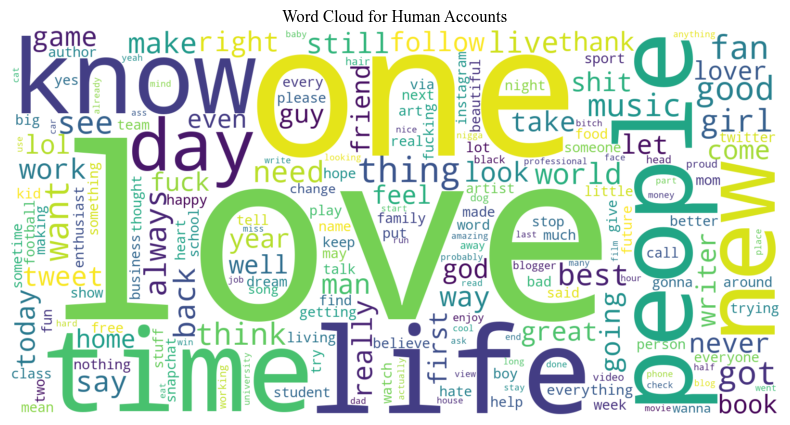

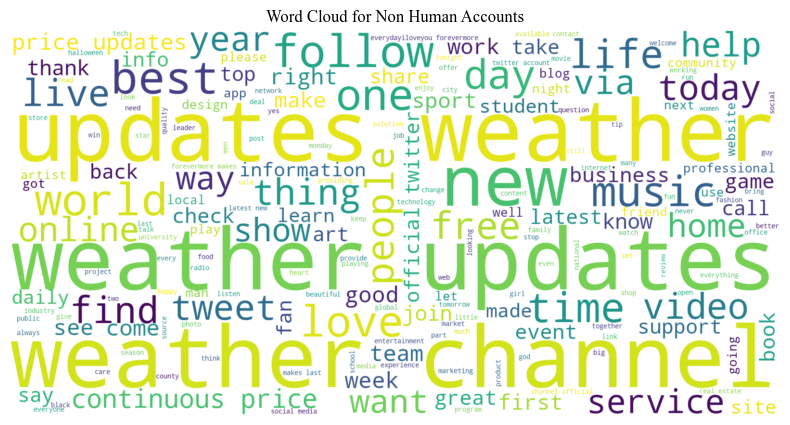

In [60]:
# Split data into two sets based on labels (0 and 1)
human_text = [new_corpus[i] for i in range(len(new_label)) if new_label[i] == 0]
bot_text = [new_corpus[i] for i in range(len(new_label)) if new_label[i] == 1]

human_text_combined = ' '.join(human_text)
bot_text_combined = ' '.join(bot_text)

# Create word cloud for human accounts
wordcloud_human = WordCloud(width=1600, height=800, background_color='white',random_state=22).generate(human_text_combined)

# Create word cloud for bot accounts
wordcloud_bot = WordCloud(width=1600, height=800, background_color='white',random_state=22).generate(bot_text_combined)

# Plot word cloud for human accounts
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_human, interpolation='bilinear')
plt.title("Word Cloud for Human Accounts")
plt.axis('off')
plt.show()

# Plot word cloud for bot accounts
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bot, interpolation='bilinear')
plt.title("Word Cloud for Non Human Accounts")
plt.axis('off')
plt.show()

### Identify the top 10 words associated with the Human vs Non-human account

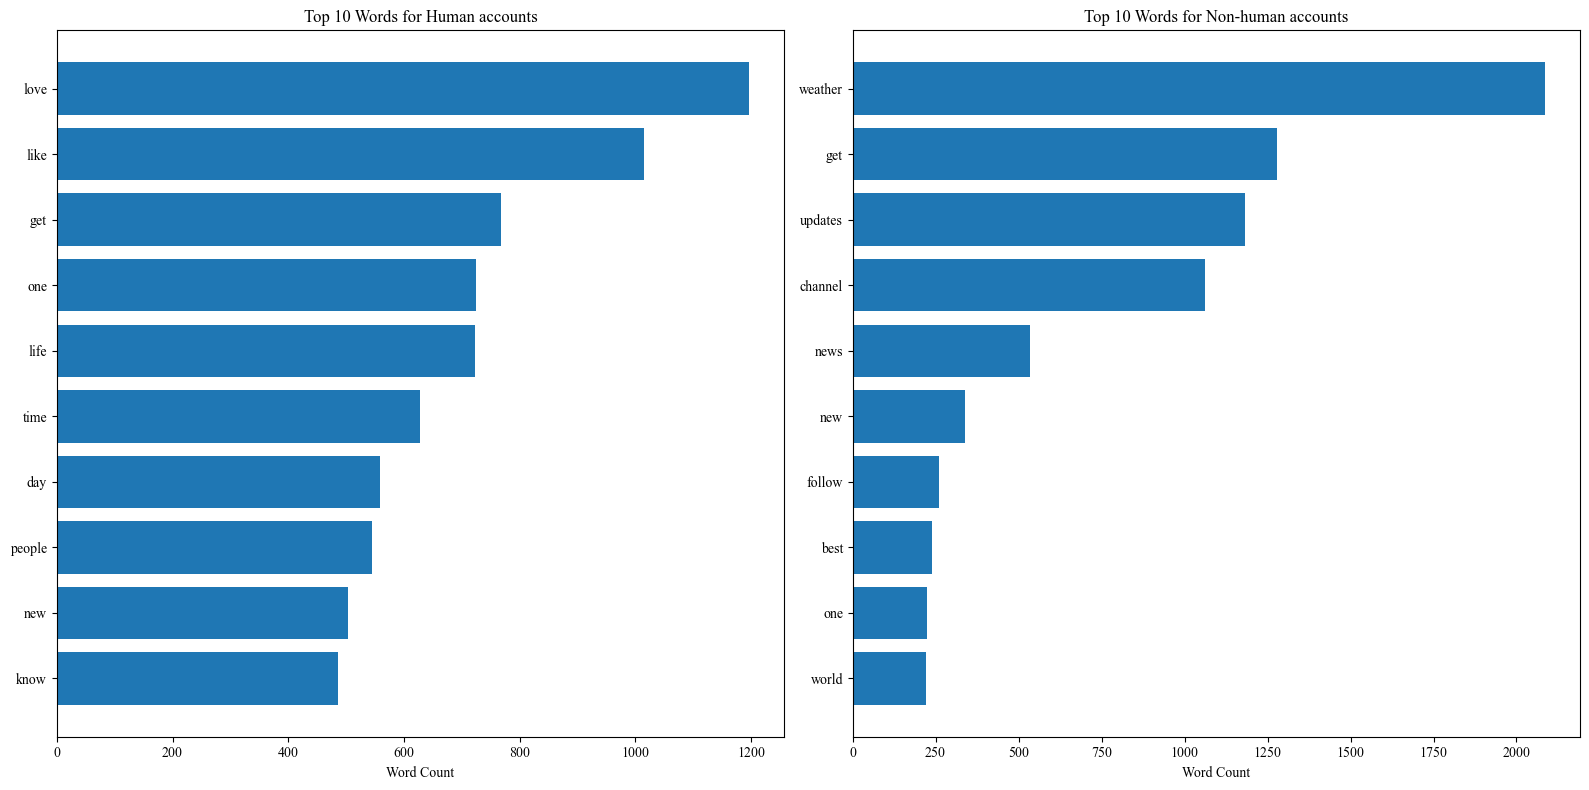

In [61]:

# Function to get the top N words from a text
def get_top_words(text, n=10):
    word_count = Counter(text.split())
    top_words = word_count.most_common(n)
    return top_words

# Get the top 10 words for human and bot categories
before_top_words_human = get_top_words(human_text_combined, n=10)
before_top_words_bot = get_top_words(bot_text_combined, n=10)

# # Plot the top 10 words for each category
plt.figure(figsize=(16, 8))

# Sort the words and counts in descending order
sorted_words_human = [word for word, count in before_top_words_human][::-1]
sorted_counts_human = [count for word, count in before_top_words_human][::-1]

sorted_words_bot = [word for word, count in before_top_words_bot][::-1]
sorted_counts_bot = [count for word, count in before_top_words_bot][::-1]

# Plot top words for humans
plt.subplot(1, 2, 1)
plt.barh(sorted_words_human, sorted_counts_human)
plt.xlabel("Word Count")
plt.title("Top 10 Words for Human accounts")

# Plot top words for bots
plt.subplot(1, 2, 2)
plt.barh(sorted_words_bot, sorted_counts_bot)
plt.xlabel("Word Count")
plt.title("Top 10 Words for Non-human accounts")

plt.tight_layout()
plt.show()


### Findings:
- The top 10 words related to human accounts predominantly reflect human-centric themes and sentiments. Words like "life", "love", and "people" suggest a focus on personal experiences, emotions, and social interac- tions. In contrast, the top 10 words for non-human accounts seem to focus on information and updates. Words like "weather", "update", "new", and "news" suggest a focus on providing or spreading information, potentially related to weather forecasts or news updates. "Channel" might indicate the platform or channel through which this information is shared.
- These distinctions could be indicative of the content and purposes associated with human and non-human accounts. Human accounts appear to focus on personal and social aspects, while non-human accounts seem to concentrate on information and updates, potentially for promotional or informative purposes.

## Train the LogisticRegression model
### Model fine tunning
- Specifically, L1 regularization with penalty=l1 was applied to encourage feature selection by penalizing less informative features. L1 regularization is known for its ability to induce sparsity in the model’s coefficients, leading some coefficients to become exactly zero (scikit-learn authors, 2022). As a result, this regularization technique automatically identifies and selects a subset of the most relevant features while effectively reducing dimensionality. 
- To address the model’s optimization problem, the liblinear solver was utilized, chosen for its suitability with datasets of moderate size. Additionally, a moderate level of regularization with C=1.0 was applied to strike a balance between model complexity and generalization. These customizations were instrumental in achieving improved model performance and predictive accuracy.

In [62]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, new_label, test_size=0.2, random_state=1)

# Train a classifier 
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1.0,random_state=1) # finetune model
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf.predict(X_val)

report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      2215
         1.0       0.83      0.63      0.71      1049

    accuracy                           0.84      3264
   macro avg       0.83      0.78      0.80      3264
weighted avg       0.84      0.84      0.83      3264



In [63]:
# Calculate the confusion matrix
conf_matrix_train = confusion_matrix(y_val, y_pred)

# Extract TP, FP, TN, FN
TP = conf_matrix_train[1, 1]  # True Positives
FP = conf_matrix_train[0, 1]  # False Positives
TN = conf_matrix_train[0, 0]  # True Negatives
FN = conf_matrix_train[1, 0]  # False Negatives

# Print the values
print(f'True Positives (TP): {TP}')
print(f'False Positives (FP): {FP}')
print(f'True Negatives (TN): {TN}')
print(f'False Negatives (FN): {FN}')

True Positives (TP): 656
False Positives (FP): 137
True Negatives (TN): 2078
False Negatives (FN): 393


### TEST WITH THE TEST DATA

In [64]:
# load the test data from test_data.csv
test_df = pd.read_csv('test_data.csv', encoding='latin-1')

In [65]:
# Pre-process the tweet of the test data
test_df['text'] = test_df['text'].apply(cleanTweet)
# preview some cleaned tweets
test_df['text'].head()

0               love sweaters boots help admire outfit
1        bermuda lodging resorts inns cottage colonies
2                   already follow also team president
3    many plant animal species book mystery origin ...
4            realist person know boy gonna make happen
Name: text, dtype: object

In [66]:
# Replace null values in "description" column with empty strings
test_df['description'].fillna('', inplace=True)
# clean dataframe's description column
test_df['description'] = test_df['description'].apply(cleanTweet)
# preview some cleaned tweets
test_df['description'].head()

0    tbh winging life eyeliner everything texas uni...
1                                                     
2    editor chief chefredakt hockeysverige podcaste...
3    theoretische forschung der naturwissenschaften...
4    exotic artist atl breaking doors taking prison...
Name: description, dtype: object

In [67]:
# Combine "text" and "description" columns
test_df['combined_text'] = test_df['description'] + ' ' + test_df['text']

In [68]:
# Vectorize the text of the test data using the same vectorizer as the training data
X_test = vectorizer.transform(test_df['combined_text'].tolist())

In [69]:
X_test.shape

(1818, 31938)

In [70]:
y_test = test_df['is_non-human'].tolist()

In [71]:
len(y_test)

1818

In [72]:
# Make predictions on the validation set
y_test_pred = clf.predict(X_test)

# Print the classification report
classification_report_test_set = classification_report(y_test, y_test_pred)

# Print the classification report
print("Classification Report for test set:")
print(classification_report_test_set)

Classification Report for test set:
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88      1246
         1.0       0.80      0.59      0.68       572

    accuracy                           0.83      1818
   macro avg       0.82      0.76      0.78      1818
weighted avg       0.82      0.83      0.82      1818



In [73]:

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Extract TP, FP, TN, FN
TP = conf_matrix[1, 1]  # True Positives
FP = conf_matrix[0, 1]  # False Positives
TN = conf_matrix[0, 0]  # True Negatives
FN = conf_matrix[1, 0]  # False Negatives

# Print the values
print(f'True Positives (TP): {TP}')
print(f'False Positives (FP): {FP}')
print(f'True Negatives (TN): {TN}')
print(f'False Negatives (FN): {FN}')


True Positives (TP): 340
False Positives (FP): 86
True Negatives (TN): 1160
False Negatives (FN): 232


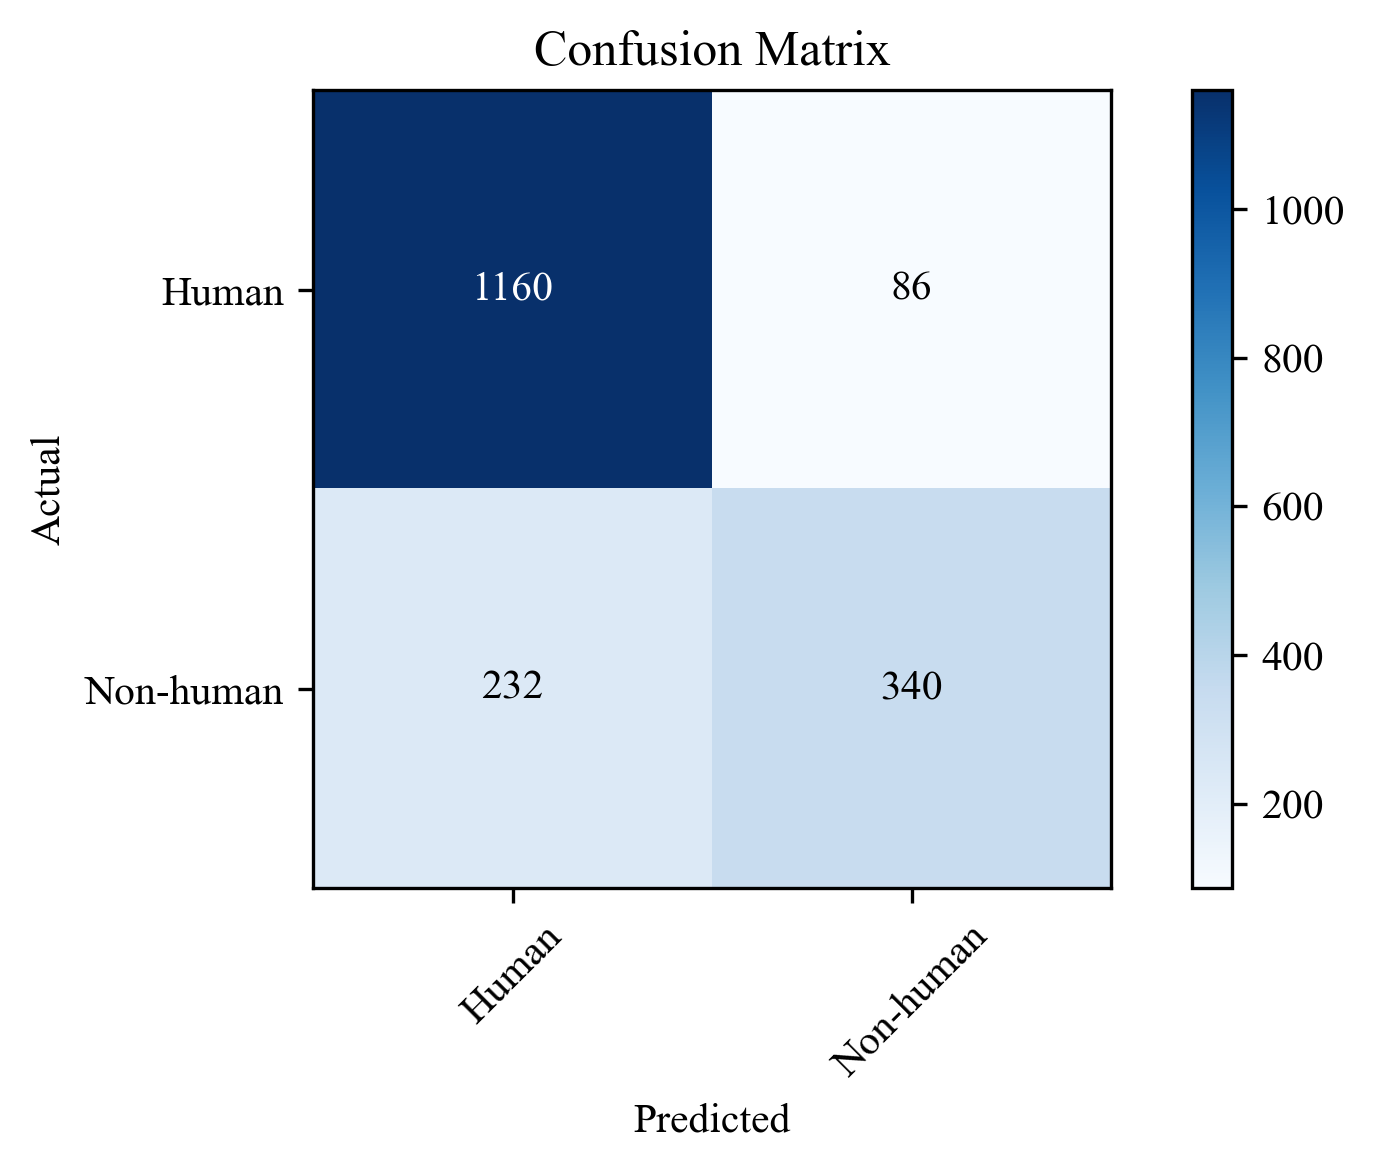

In [74]:
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(6, 4),dpi=300)
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Human', 'Non-human']  
tick_marks = [0, 1]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(2):
    for j in range(2):
        color = 'white' if i == 0 and j == 0 else 'black'  # White text for TN, black text for others
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color=color)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


## CONCLUSION:
The model achieved good precision (83%) and recall (93%)for class 0 (human), indicating its reliability in identifying human tweets while capturing most actual human tweets.
- However,for class 1 (non-human), precision remained high(80%),but recall was lower(59%),suggesting some non-human tweets may be misclassified as human.
- F1-scores provided a balanced perspective with class 0 at 0.88 and class 1 at 0.68.
- The overall accuracy of the model on the test set was 83%, indicating strong performance in correctly detecting human tweets and room for improvement in identifying non-human tweets.

### Limitations:
- Simple Feature Extraction: The model uses a bag of words approach, which, while effective, is relatively simple and may not capture the full complexity of the text data.
- Imbalanced Recall: The recall for class 1 (non-human) is significantly lower (59%) compared to class 0 (human), indicating that the model struggles to correctly identify a substantial portion of non-human tweets.
- Data Limitations: The classification model is limited by the available data, which may lack a comprehensive ground truth for accurately distinguishing between human and bot tweets.
### Suggestions for Improvement:
- Advanced Feature Extraction: Implementing more sophisticated text representation techniques such as TF-IDF (Term Frequency-Inverse Document Frequency) could provide richer features for the model, potentially improving classification performance.
- Enhanced Model Techniques: Explore and experiment with different machine learning models for better handling sequential data.
- Increase Training Data: Collect more labeled data to improve the model's learning capability and ensure a more robust ground truth. This can help in better training the model, especially in identifying non-human tweets.


## REFERRENCES:
- Adom, S. A. . T. L. . I. T. (2022). Comparing bag of words and tf-idf with different models for hate speech detection from live tweets. https://link.springer.com/article/10.1007/s41870-022-01096-4. 
- scikit learn. (2022). Countvectorizer. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html. 
- scikit learn. (2023). Logistic regression. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. 
- Wahome, R. (2018). This is how twitter sees the world : Sentiment analysis part one. https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-one-5ac2d06b63fb. 
